# Задача 8

### В роман одного автора (Льва Толстого) поместили несколько абзацев другого (Михаила Зощенко). Предложить алгоритм, который бы находил бы смену стиля автора (кроме этого текста ничего нет, авторов мы не знаем). Можно представить текст как набор временных рядов или предложить другой способ представления текста для анализа.

#### В качестве данных использовались первые две части первого тома "Войны и Мира" Толстого. В этот текст был помещен рассказ М.Зощенко "История болезни".

In [337]:
#Подключаем необходимые библиотеки
%matplotlib inline

import io
import string

import random

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import svm

Сначала преобразуем текст к удобному для выделения признаков виду. Считаем текстовый файл, из которого удалим все пунктационные знаки и отрывки иностранных языков(т.к. анализ стиля автора будет основан на характеристиках русского языка), представив его как массив слов.

In [338]:
in_data = open(r'''C:\test\1709.txt''')
list = in_data.readlines()

#определяем символы, от которых следует избавиться
delimiters = ['\n', '[', ']', ';', '—', ' ', ',', '.', '?', '!', ':', '(', ')', '«', '»', "'"]
delimiters += ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n','o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y','z']
delimiters += ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N','O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y','Z']

#последовательно удаляем их
words = list
for delimiter in delimiters:
    new_words = []
    for word in words:
        new_words += word.split(delimiter)
    words = new_words
    
while '' in words:
    words.remove('')

#чтобы в дальнейшем оценить ошибку обученной модели, определим положение рассказа в тексте 

begin = 0 #начало 
end = 0 #конец
    
for i in range(len(words)): 
    if words[i] == '*' and begin == 0: begin = i
    elif words[i] == '*': end = i
        
#приведем все буквы к нижнему регистру
for i in range(len(words)): 
    words[i] = words[i].lower()

print("Количество слов во рассказе Зощенко: " + str(end - begin) + ", что составляет " + str(100*(end - begin)/len(words)) + "% от общего объема текста")
#for x in words: print(x)

Количество слов во рассказе Зощенко: 784, что составляет 2.9214488001192427% от общего объема текста


In [355]:
#Количество слов в исходном фрагменте
Num_Samples = len(words)
print("Исходный фрагмент состоит из " + str(Num_Samples) + " слов")

#Количество слов в одной выборке
Length_Sample = 7
print("Для каждой выборки возьмем по " + str(Length_Sample) +  " слов(а)")

#сколько будет создано выборок для обучения
Volume = round(0.8*Num_Samples)
Volume = 20000
print("Создаем " + str(Volume) + " выборок для обучения ")

Исходный фрагмент состоит из 26836 слов
Для каждой выборки возьмем по 7 слов(а)
Создаем 20000 выборок для обучения 


In [356]:
Samples = [] #массив строк
Class = [0.2]*Volume #классификация выборок для оценки эффективности

#получаем выборку, выбирая начало фрагмента случайным образом
for i in range(0, Volume-1):
    a = random.randint(1, Num_Samples-Length_Sample-2)
    if a >= begin and a < end - Length_Sample: Class[i] = 0
    for j in range(Length_Sample):       
        Samples.append('')
        Samples[i] += words[a+j]
        Samples[i] += ' '
    Samples[i] = str(Samples[i])
    
        
#for i in range(Volume): print(Samples[i])

In [357]:
#формируем массив 50-ти самых часто используемых биграмм русского языка

bigramms = ['ав', 'ан','ва', 'ве', 'во','го','ел','ен','за','ин']

bigramms += ['ко', 'ле','ли','ло','на','не','ни','но','ов','ог']

bigramms += ['од', 'ол','ом','он','ло','ас','ер','ес','ет','ль']

bigramms += ['ны', 'ор','ос','от','пр','ра','ре','ро','ск','та']

bigramms += ['те', 'ти','то','ст','де','ои','ис','ит','об','ее']


Для каждой строки из созданного массива фрагментов определяем значение признаков. Всего признаков будет 50: ими будет частота использования каждой из биграмм.

In [358]:
#формируем матрицу признаков
dataset = [[0] * 51 for i in range(Volume)]

for i in range(Volume):
    dataset[i][50] = Class[i]
    for j in range(0,49):
        for k in range(0, len(Samples[i])-1):
            if str(Samples[i][k]+Samples[i][k+1]) == str(bigramms[j]): dataset[i][j] +=1/50
                
X = dataset

#отправляем на обучение 70% матрицы
from sklearn.cross_validation import train_test_split as train
X_train, X_test = train(X,test_size = 0.3,random_state = 42)    

    
#for line in dataset: print(line)

In [359]:
#параметр вывода массива
#import numpy 
#numpy.set_printoptions(threshold=numpy.nan)

#задаем классификатор
clf = svm.OneClassSVM(nu=0.1,kernel = "linear", gamma =0.1)
y_score = clf.fit(X_train)
pred = clf.predict(X_test)

#значение будущей ошибки
#ошибку будем определять как отношение неправильно классифицированных фрагментов к общему числу выборок
error = 0

for i in range(len(X_test)): 
    if pred[i] == 1 and X_test[i][50] == 0:error += 1/len(X_test)
    elif pred[i] == -1 and X_test[i][50] == 0.2:error += 1/len(X_test)
    #elif pred[i] == -1: print(X_test[i])

print(error)
#print(pred)

0.07316666666666677


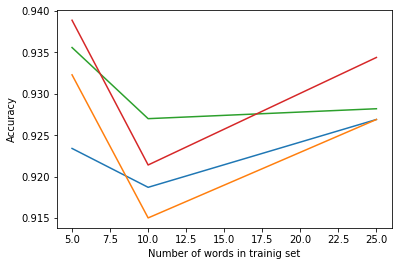

In [361]:
k = [5, 10, 25]
accur = [[0.9234, 0.9323, 0.9356, 0.9389], [0.9187, 0.915, 0.927, 0.9214], [0.9269, 0.9269, 0.9282, 0.9344]]


plt.xlabel('Number of words in trainig set')
plt.ylabel('Accuracy')
plt.plot(k, accur)
plt.show()